In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
#from pymer4.models import Lmer
#from pymer4.stats import rsquared, rsquared_adj
import re

In [2]:
inPATH = '../data/training/iapar/cper_biomass_iapar_2014_2022.csv'
inPATH_grazing = '../data/ground/grazing/CARM_ActualGrazingInfov3_2013-2023.csv'

outPATH = '../data/training/iapar/model_selection/cper_biomass_iapar_2014_2022_all.csv'

In [3]:
df = pd.read_csv(inPATH, parse_dates=True)
df_grazing = pd.read_csv(inPATH_grazing)

In [4]:
df_grazing[df_grazing['PastureCode'] == 'NH'] = '10S'

In [5]:
df = df.dropna(subset=['Date', 'Total_Biomass', 'iAPAR']).copy().reset_index()

In [6]:
df_grazing_in = pd.merge(df, df_grazing[['PastureCode', 'Year', 'DateInPasture']],
         left_on=['Pasture', 'Year'],
         right_on=['PastureCode', 'Year'],
         how='left')

In [7]:
df_grazing_in = df_grazing_in.set_index('index')

In [8]:
df = df.set_index('index')

In [9]:
df['DateInPasture'] = df_grazing_in.drop_duplicates(subset=['Id', 'Year'], keep='first')['DateInPasture']

In [10]:
df['DateInPasture'] = pd.to_datetime(df['DateInPasture'])

In [11]:
df['Date'] = pd.to_datetime(df['Date'])

In [12]:
def calc_graze_timing(x):
    if x['Treatment'] in ['TGM']:
        timing = 'Season-long moderate'
    elif x['Treatment'] in ['NEW_HVY']:
        timing = 'Season-long heavy'
    else:
        if pd.isnull(x['DateInPasture']):
            timing = 'Ungrazed'
        elif x['DateInPasture'] > x['Date']:
            timing = 'Ungrazed'
        elif x['DateInPasture'].dayofyear > 206:
            timing = 'Ungrazed'
        elif x['DateInPasture'].dayofyear <= 206:
            timing = 'Pulse-grazed'
    return timing
        

In [13]:
#df

In [14]:
df['Graze_timing'] = df.apply(lambda x: calc_graze_timing(x), axis=1)

In [15]:
df["Total_Biomass_sqrt"] = np.sqrt(df['Total_Biomass'])
df['Block'] = df['Block'].astype(int).astype(str)

In [16]:
df['Ecosite'] = pd.Categorical(df['Ecosite'],
                               categories=['Loamy', 'Sandy', 'Salt Flats'])
df['Graze_timing'] = pd.Categorical(df['Graze_timing'],
                               categories=['Ungrazed', 'Season-long moderate', 'Season-long heavy', 'Pulse-grazed'])

In [17]:
df['Graze_timing'].value_counts()

Season-long moderate    426
Ungrazed                214
Pulse-grazed            212
Season-long heavy        48
Name: Graze_timing, dtype: int64

In [18]:
df.groupby('Graze_timing')['Year'].value_counts()

Graze_timing          Year
Ungrazed              2015    36
                      2016    32
                      2021    30
                      2017    28
                      2018    24
                      2019    22
                      2014    20
                      2022    12
                      2020    10
Season-long moderate  2017    48
                      2018    48
                      2019    48
                      2020    48
                      2021    48
                      2022    48
                      2014    46
                      2015    46
                      2016    46
Season-long heavy     2019    12
                      2020    12
                      2021    12
                      2022    12
Pulse-grazed          2020    38
                      2022    36
                      2014    26
                      2019    26
                      2018    24
                      2017    20
                      2021    18
                

In [19]:
#df.to_csv(outPATH, index=False)

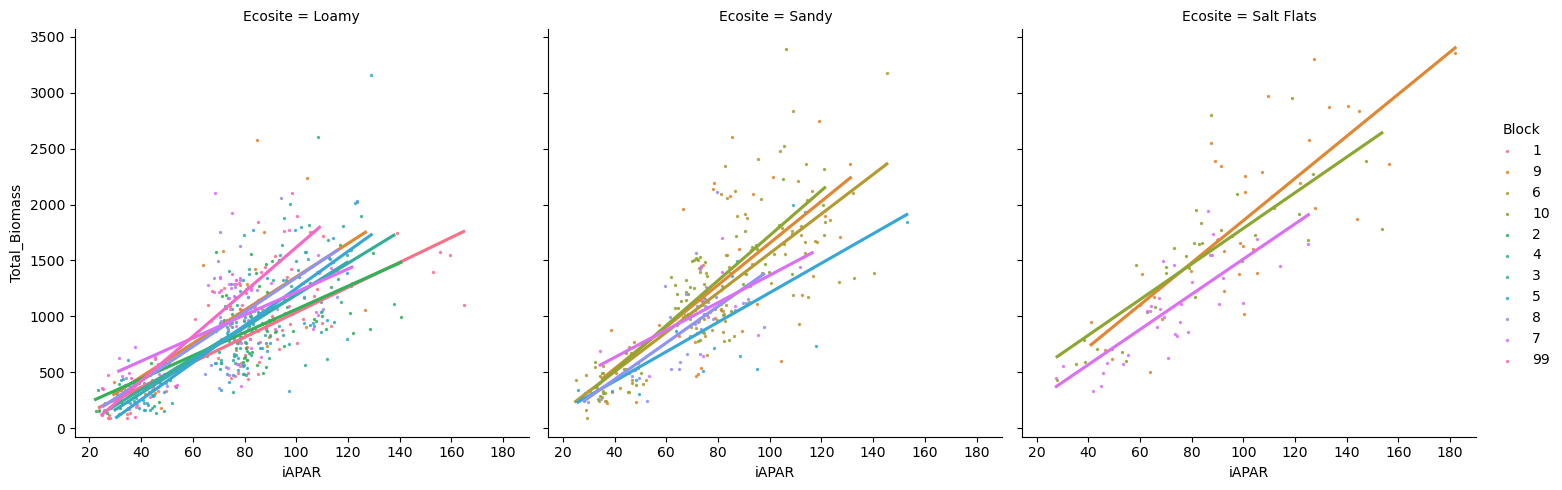

In [21]:
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Block', ci=None, col='Ecosite', 
           data=df,#.groupby(['Pasture', 'Year', 'Ecosite', 'Graze_timing']).mean().reset_index(),
           scatter_kws={'s': 2})

<Figure size 1200x1200 with 0 Axes>

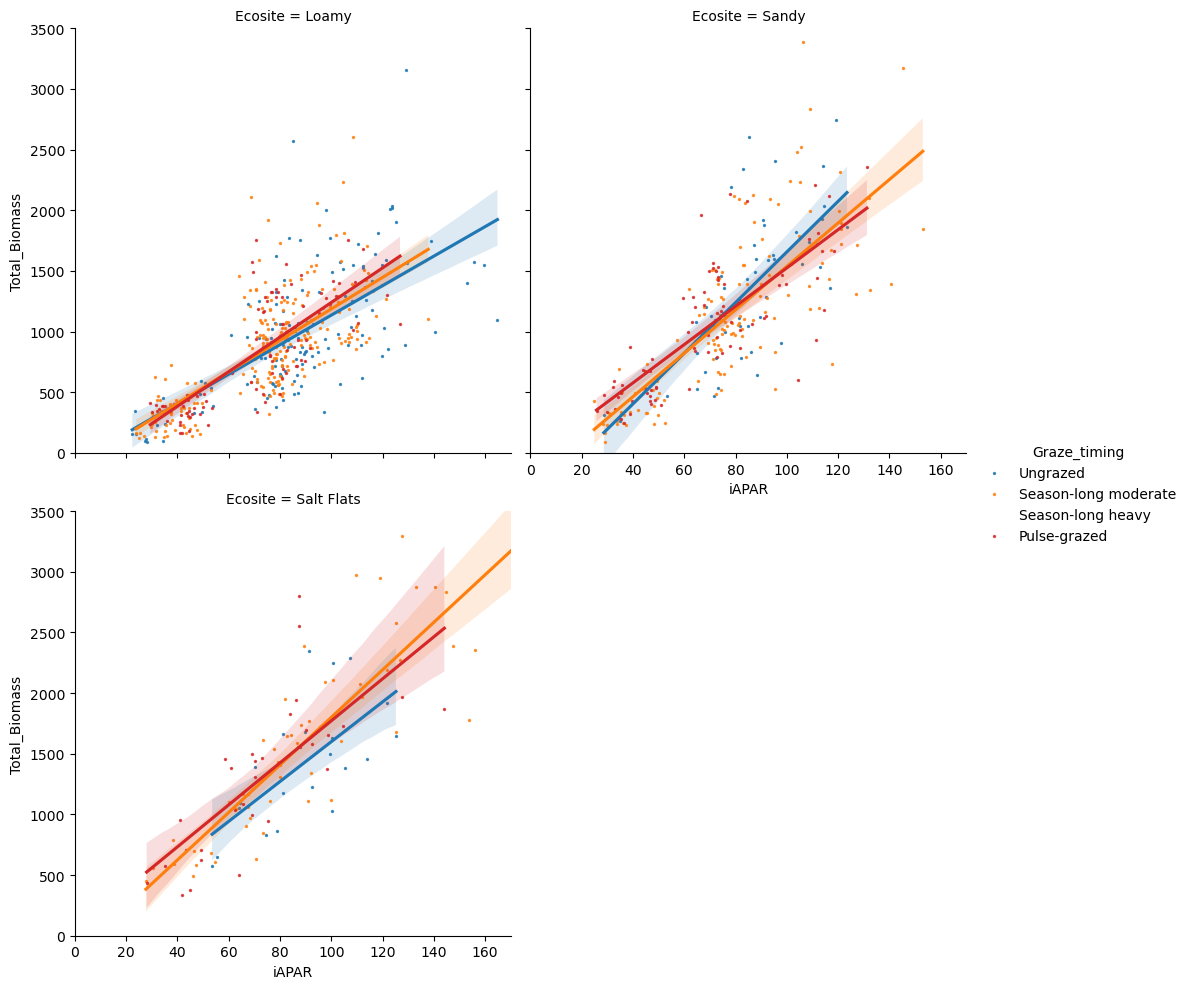

In [25]:
plt.figure(figsize=(12, 12))
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Graze_timing', ci=95, col='Ecosite', col_wrap=2,
           data=df[df['Graze_timing'] != 'Season-long heavy'],#.groupby(['Pasture', 'Year', 'Ecosite', 'Graze_timing']).mean().reset_index(),
           scatter_kws={'s': 2})
plt.ylim((0, 3500))
plt.xlim((0, 170))
plt.show()

<Figure size 1200x1200 with 0 Axes>

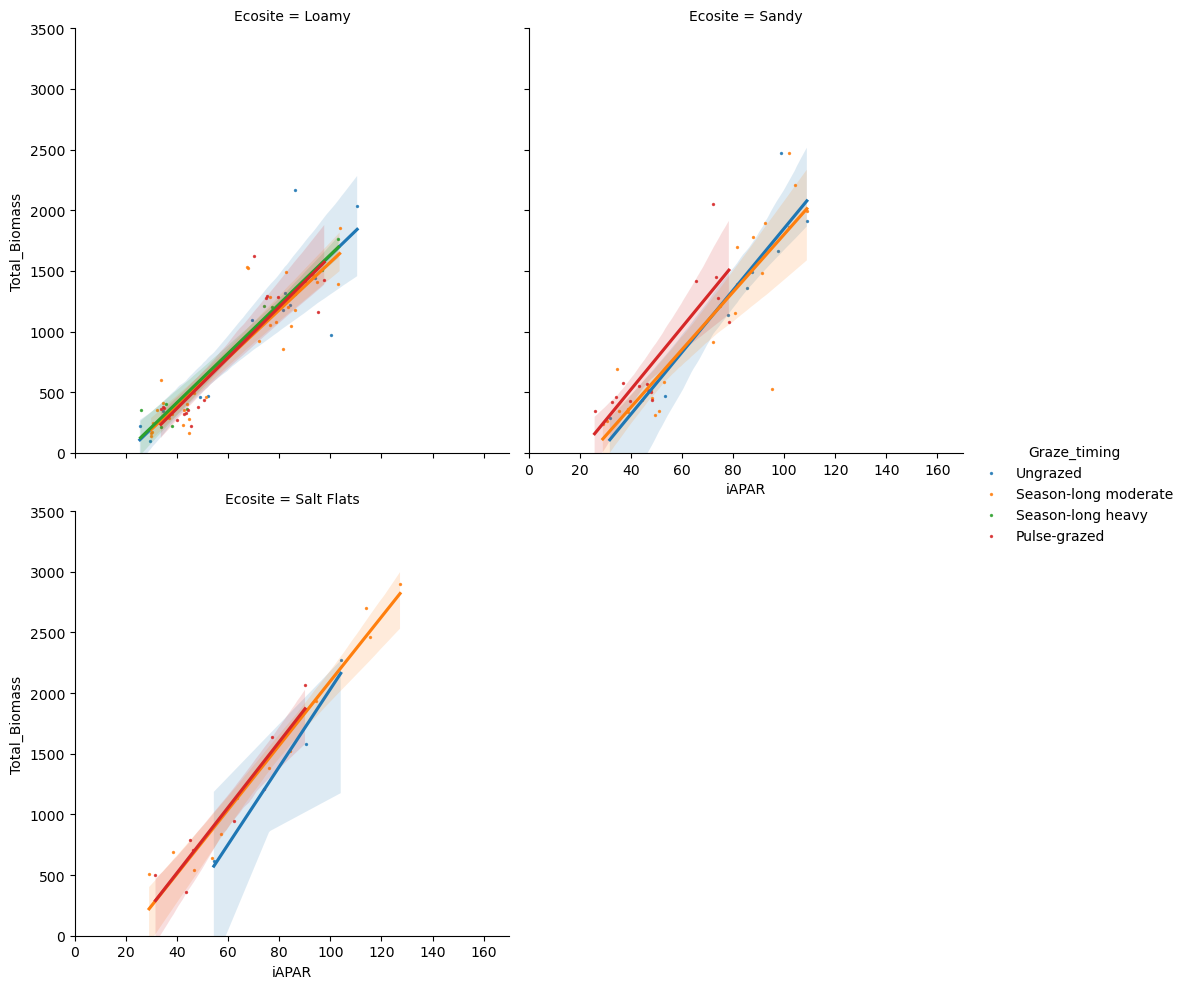

In [138]:
plt.figure(figsize=(12, 12))
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Graze_timing', ci=95, col='Ecosite', col_wrap=2,
           data=df[df['Year'] >= 2019],#.groupby(['Pasture', 'Year', 'Ecosite', 'Graze_timing']).mean().reset_index(),
           scatter_kws={'s': 2})
plt.ylim((0, 3500))
plt.xlim((0, 170))
plt.show()